# Identifying Pneumonia in Lung X-Rays Using Neural Networks
#### Justin Fernandez and Lauren Phipps

## Overview <a id="Overview"></a>

insert overview here


[1. Business Problem](#Business-Problem)

[2. Data Understanding](#Data-Understanding)

[3. Data Preparation](#Data-Preparation)

[4. EDA](#EDA)

[5. Modeling](#Modeling)

[6. Evaluation](#Evaluation)

[7. Conclusion](#Conclusion)

***

## Business Problem <a id="Business-Problem"></a>
##### [(back to top)](#Overview)

Pneuomonia is an infection in the lungs causes the air sacs to fill with fluid making it difficult to breathe, particularly for older patients, very young patients, or patients with weakened immune systems. Diagnosis comes from identifying the infection, seen as white spots, with a chest x-ray. However, it can sometimes be challenging for humans to spot these abnormalities, so neural networks can be beneficial for analyzing and classifying lung x-rays of pneumonia patients. This project aims to create a neural network that, given an image of a chest x-ray, correctly identify whether or not the patient has pneumonia. Approximately 50,000 people per year die of pneumonia in the United States alone, therefore, it is incredibly important to accurately identify patients suffering from pneumonia to get them the treatment that they need. 

***

## Data Understanding <a id="Data-Understanding"></a>
##### [(back to top)](#Overview)

The data for this project is a collection of images of chest x-rays from both healthy patients and patients with pneumonia. These were broken into three sets: a training set, a validation set, and a testing set. They were loaded in and separated into their respective data sets. 

In [3]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import os
import PIL
import PIL.Image
import tensorflow as tf
import glob
import pathlib
from pathlib import Path

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [27]:
# Directory path
train_data_dir = 'chest_xray/chest_xray/train/'
val_data_dir = 'chest_xray/chest_xray/val/'
test_data_dir = 'chest_xray/chest_xray/test/'


# Getting the testing data and resizing the images
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(64, 64), batch_size=600)

# Getting the validation set and resizing the images
val_generator = ImageDataGenerator().flow_from_directory(
        val_data_dir, 
        target_size=(64, 64), batch_size=16)

# Getting the training set and resizing the images
train_generator = ImageDataGenerator(horizontal_flip=True).flow_from_directory(
        train_data_dir, 
        target_size=(64, 64), batch_size=5200)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

# Create groups for normal images and pneuomonia images within training set
normal_imgs = [fn for fn in os.listdir(f'{train_data_dir}/NORMAL') if fn.endswith('.jpeg')]
pneumonia_imgs = [fn for fn in os.listdir(f'{train_data_dir}/PNEUMONIA') if fn.endswith('.jpeg')]


Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


There are 5,216 images in the training set, 16 images in the validation set, and 624 in the testing set.

In [30]:
print('There are', len(normal_imgs), 'normal images in the training set.')
print('There are', len(pneumonia_imgs), 'pneumonia images in the training set.')

There are 1341 normal images in the training set.
There are 3875 pneumonia images in the training set.


This indicates that there is a slight class imbalance in the data set, with pneumonia x-rays as the dominant class. 

The images are stored as RBG values for each pixel in the 64x64 image, shown below.

In [20]:
train_images[0]

array([[[101., 101., 101.],
        [ 99.,  99.,  99.],
        [ 52.,  52.,  52.],
        ...,
        [ 61.,  61.,  61.],
        [ 57.,  57.,  57.],
        [ 56.,  56.,  56.]],

       [[ 91.,  91.,  91.],
        [ 98.,  98.,  98.],
        [105., 105., 105.],
        ...,
        [ 56.,  56.,  56.],
        [ 54.,  54.,  54.],
        [ 49.,  49.,  49.]],

       [[ 88.,  88.,  88.],
        [ 80.,  80.,  80.],
        [ 97.,  97.,  97.],
        ...,
        [ 60.,  60.,  60.],
        [ 52.,  52.,  52.],
        [ 38.,  38.,  38.]],

       ...,

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [ 29.,  29.,  29.],
        [  8.,   8.,   8.],
        [  0.,   0.,   0.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [ 29.,  29.,  29.],
        [ 11.,  11.,  11.],
        [  0.,   0.,   0.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,  

However, they can be visualized as an image, shown below here.

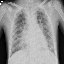

In [17]:
array_to_img(train_images[15])

The labels consist of values of either `0, 1` or `1, 0` with `0, 1` denoting that the patient has pneumonia and `1, 0` denoting that it is normal.

In [18]:
train_labels[15]

array([0., 1.], dtype=float32)

The image shown above has pneumonia.

In [21]:
print('The shape of the train images is:', np.shape(train_images))
print('The shape of the train labels is:', np.shape(train_labels))
print('The shape of the test images is:', np.shape(test_images))
print('The shape of the test labels is:', np.shape(test_labels))
print('The shape of the validation images is:', np.shape(val_images))
print('The shape of the validation labels is:', np.shape(val_labels))

The shape of the train images is: (5200, 64, 64, 3)
The shape of the train labels is: (5200, 2)
The shape of the test images is: (600, 64, 64, 3)
The shape of the test labels is: (600, 2)
The shape of the validation images is: (16, 64, 64, 3)
The shape of the validation labels is: (16, 2)


***

## Data Preparation <a id="Data-Preparation"></a>
##### [(back to top)](#Overview)

To prepare for modeling, the shape of the data set needed to change. 

## EDA <a id="EDA"></a>
##### [(back to top)](#Overview)


The models will be trying to identify the white, cloudy spots of chest x-ray that indicate pneuomonia. An example of an x-ray from a healthy patient is below. 

***image of healthy***

Compare that with the x-ray from a pneuomonia patient below. The white spots (marked) indicate the infection. This is what the model will be looking for. 

***image of pneumonia***

In order to look deeper at the pixel data from the images, we combined all the data from the normal and pneumonia images into one matrix for each label. 

In [33]:
# making n X m matrix of all normal and pneumonia images of the training set, 
# where n = number of observations and m = the number of pixels
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

#apply function to images
normal_images = img2np(f'{train_data_dir}/NORMAL/', normal_imgs)
pneumonia_images = img2np(f'{train_data_dir}/PNEUMONIA/', pneumonia_imgs)

From here, we could find the average pixel value for each label type and the standard deviation of the pixel values.

In [ ]:
print('The average pixel value for normal images is ', np.mean(normal_images))
print('The average pixel value for pneumonia images is ', np.mean(pneumonia_images))
print('The standard deviation of pixels for normal images is ', np.std(normal_images))
print('The standard deviation of pixels for pneumonia images is ', np.std(pneumonia_images))

The means are very similar with the pneumonia images being slightly higher. This could be due to the whiter spots having a higher pixel value. Additionally, the standard deviation is higher for the normal images, which can be attributed to the overall greater contrast within the images since they do not have the white spots indicating pneumonia.

The mean images for the normal and pneumonia images are shown below. 

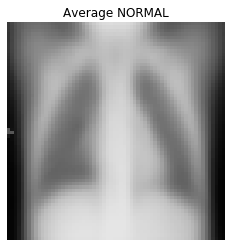

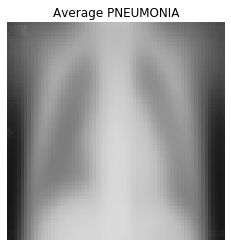

In [36]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean = find_mean_img(normal_images, 'NORMAL')
pneu_mean = find_mean_img(pneumonia_images, 'PNEUMONIA')

These images show the variability that occurs in pneumonia x-rays throughout the lungs. Most healthy patients have lung x-rays that look similar; however, pneumonia can appear at any place within the lungs, creating the general cloudiness in the image above. This can also be seen through the standard deviation of the images below. 

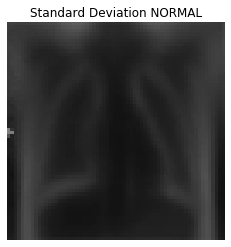

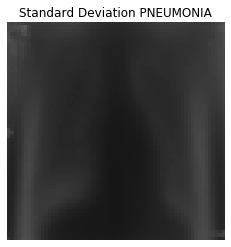

In [38]:
def find_std_img(full_mat, title, size = (64, 64)):
    # calculate the standard deviation
    std_img = np.std(full_mat, axis = 0)
    # reshape it back to a matrix
    std_img = std_img.reshape(size)
    plt.imshow(std_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Standard Deviation {title}')
    plt.axis('off')
    plt.show()
    return std_img

norm_std = find_std_img(normal_images, 'NORMAL')
pneu_std = find_std_img(pneumonia_images, 'PNEUMONIA')

Again, there is less clear distinction within the pneumonia images due to the presence of the white spots at different locations in the lungs. 

## Modeling <a id="Modeling"></a>
##### [(back to top)](#Overview)

The first step was to create a standard sequential neutral network with several dense layers. Because it is a binary classification problem, a sigmoid function was used for the output layer.

#### Vanilla Model

#### CNN #1

#### CNN with tuning

#### CNN with augmentation

#### Final model

In [ ]:
## Vanilla

From this model we can see that.... 

In [ ]:
## CNN 1

Initially, this model's accuracy was a bit lower, so additional convolutional layers were added in the next interation, as well as more dense layers and drop layers. The drop layers help prevent the model from overfitting by dropping some of the data at each spot, which keeps the model from simply memorizing the training set. 

In [ ]:
## CNN 2

The metrics for this model improved with the additional tuning and increased layers. 

Next, we wanted to continue to improve the accuracy, while also addressing the class imbalance. To do this, we augmented the images by rotating some of the images and adding them into the data set. This provides the model with more information and, again, helps with overfitting as it cannot simply memorize images that look very similar. To do this, a new data set was created as shown below. 

In [ ]:
## code for augmenting

## Evaluation <a id="Evaluation"></a>
##### [(back to top)](#Overview)

For this project, we focused on the recall and accuracy score. With identifying pneumonia, it is more important to minimize false negatives, as it is worse to say someone does not have pneumonia when they do and have them not receive treatment. In order to ensure we were minimized false negatives, we used recall. We also used accuracy as the measure between sets to determine if models were overfit or underfit.

#### Metrics (recall, f1, accuracy)
#### Confusion Matrix
#### False positives vs False negatives (images)
#### ROC Curve

## Conclusion <a id="Conclusion"></a>
##### [(back to top)](#Overview)